# Cropping a domain using the lat/lon convex hull of another domain

This notebook demonstrates how convex hull based cropping works in `mllam-data-prep`.

This method crops a domain using the lat/lon convex hull of another domain. This is useful when a) you have two datasets on two different overlapping domains where you only want to keep the overlapping part, or b) in the case where you want to run limited-area simulations and need to create a dataset that provides the boundary conditions for the limited-area domain.

In [1]:
import tests.data as testdata
import tempfile

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import mllam_data_prep as mdp
import tests.data as testdata
from mllam_data_prep.ops import cropping    

We will start by creating the some synthetic data on two different domains where one sits within the other, mimicking the scenario where you have a high-resolution dataset within a coarser dataset.

In [2]:
tmpdir = tempfile.TemporaryDirectory()
l = 500 * 1.0e3  # length and width of domain in meters
N = 50  # number of grid points in each direction
config_lam = testdata.create_input_datasets_and_config(
    identifier="lam",
    data_categories=["state"],
    tmpdir=tmpdir,
    xlim=[-l/2.0, l/2.0],
    ylim=[-l/2.0, l/2.0],
    nx=N, ny=N,
    add_latlon=True

)
# make the global domain twice as large as the LAM domain so that the lam
# domain is contained within the global domain, but half the number of grid
# points in each direction
config_global = testdata.create_input_datasets_and_config(
    identifier="global",
    data_categories=["state"],
    tmpdir=tmpdir,
    xlim=[-l, l],
    ylim=[-l, l],
    nx=N//2, ny=N//2,
    add_latlon=True
)


In [3]:
ds_lam = mdp.create_dataset(config=config_lam)
ds_global = mdp.create_dataset(config=config_global)

2025-01-08 17:48:34.313 | INFO     | mllam_data_prep.create_dataset:create_dataset:144 - Loading dataset lam_surface_analysis from /var/folders/n8/kcprfkd918967drydbc_bphw0000gr/T/tmp0tflm74d/lam/surface_analysis_c6f5cd46-48fd-4f02-8a6a-fde52bf31d69.zarr
2025-01-08 17:48:34.359 | INFO     | mllam_data_prep.create_dataset:create_dataset:169 - Mapping dimensions and variables for dataset lam_surface_analysis to state
2025-01-08 17:48:34.362 | INFO     | mllam_data_prep.create_dataset:_merge_dataarrays_by_target:49 - Merging dataarrays for target variable `state`
2025-01-08 17:48:34.363 | INFO     | mllam_data_prep.create_dataset:create_dataset:204 - Chunking dataset with {}
2025-01-08 17:48:34.364 | INFO     | mllam_data_prep.create_dataset:create_dataset:144 - Loading dataset global_surface_analysis from /var/folders/n8/kcprfkd918967drydbc_bphw0000gr/T/tmp0tflm74d/global/surface_analysis_8c2f2bb4-5767-4180-9b5a-374afa4ce05d.zarr
2025-01-08 17:48:34.367 | INFO     | mllam_data_prep.creat

In [4]:
ds_lam

<xarray.Dataset> Size: 200kB
Dimensions:                       (time: 5, grid_index: 2500, state_feature: 1)
Coordinates:
  * time                          (time) datetime64[ns] 40B 2000-01-01 ... 20...
    lat                           (grid_index) float64 20kB dask.array<chunksize=(2500,), meta=np.ndarray>
    lon                           (grid_index) float64 20kB dask.array<chunksize=(2500,), meta=np.ndarray>
    x                             (grid_index) float64 20kB dask.array<chunksize=(2500,), meta=np.ndarray>
    y                             (grid_index) float64 20kB dask.array<chunksize=(2500,), meta=np.ndarray>
  * state_feature                 (state_feature) <U15 60B 'pres_seasurface'
    state_feature_units           (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_long_name       (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_source_dataset  (state_feature) <U20 80B dask.array<chunksize=(1,), meta=np.ndarray>
  * grid_index                    (grid_index) int64 20kB 0 1 2 ... 2498 2499
Data variables:
    state                         (state_feature, time, grid_index) float64 100kB dask.array<chunksize=(1, 5, 2500), meta=np.ndarray>
Attributes:
    schema_version:   v0.5.0
    dataset_version:  v0.1.0
    created_on:       2025-01-08T17:48:34
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    mdp_version:      v0.5.0

In [5]:
ds_global

<xarray.Dataset> Size: 50kB
Dimensions:                       (time: 5, grid_index: 625, state_feature: 1)
Coordinates:
  * time                          (time) datetime64[ns] 40B 2000-01-01 ... 20...
    lat                           (grid_index) float64 5kB dask.array<chunksize=(625,), meta=np.ndarray>
    lon                           (grid_index) float64 5kB dask.array<chunksize=(625,), meta=np.ndarray>
    x                             (grid_index) float64 5kB dask.array<chunksize=(625,), meta=np.ndarray>
    y                             (grid_index) float64 5kB dask.array<chunksize=(625,), meta=np.ndarray>
  * state_feature                 (state_feature) <U15 60B 'pres_seasurface'
    state_feature_units           (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_long_name       (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_source_dataset  (state_feature) <U23 92B dask.array<chunksize=(1,), meta=np.ndarray>
  * grid_index                    (grid_index) int64 5kB 0 1 2 3 ... 622 623 624
Data variables:
    state                         (state_feature, time, grid_index) float64 25kB dask.array<chunksize=(1, 5, 625), meta=np.ndarray>
Attributes:
    schema_version:   v0.5.0
    dataset_version:  v0.1.0
    created_on:       2025-01-08T17:48:34
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    mdp_version:      v0.5.0

Let's first make a mask that indicates which of the coarser domain grid-points are within the convex hull of the high-resolution grid points coordinates

In [6]:
da_interior_mask = cropping.create_convex_hull_mask(ds=ds_global, ds_reference=ds_lam)

In [7]:
da_interior_mask = da_interior_mask.where(da_interior_mask, drop=True)

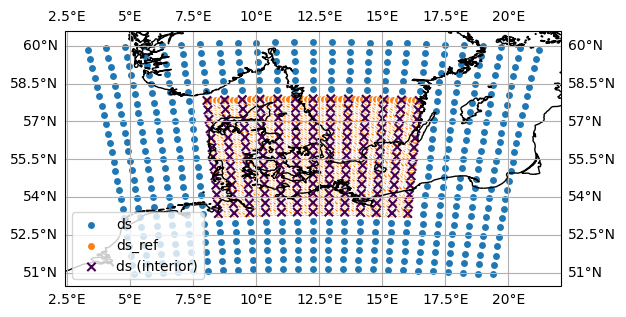

In [8]:
ds_reference = ds_lam
ds = ds_global

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
xr.plot.scatter(ax=ax, ds=ds, x="lon", y="lat", label="ds", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, ds=ds_reference, x="lon", y="lat", label="ds_ref", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, c=da_interior_mask, ds=da_interior_mask.to_dataset(name="mask"), x="lon", y="lat", marker="x", label="ds (interior)")
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.legend()
plt.show()
    

Next we will for the points from the larger domain and exterior to this convex hull (i.e. points excluded by the mask created above) compute the distance to the nearest point of the inner domain.

In [9]:
da_dist = cropping.distance_to_convex_hull_boundary(ds=ds_global, ds_reference=ds_lam)

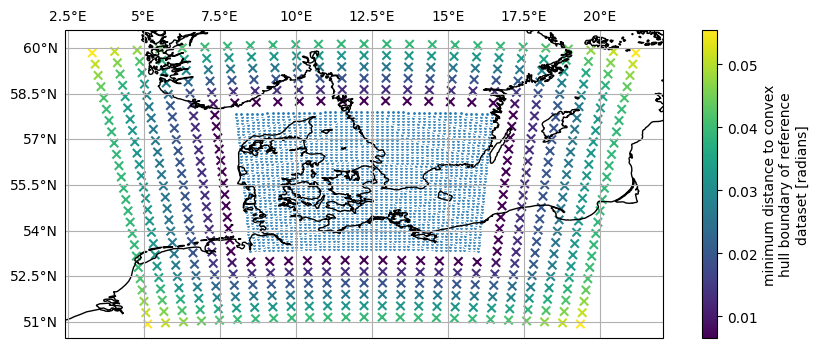

In [10]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 4))
xr.plot.scatter(ax=ax, ds=ds_reference, x="lon", y="lat", label="ds_ref", marker=".", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, hue="dist", ds=da_dist.to_dataset(name="dist"), x="lon", y="lat", marker="x", label="ds (distance)", add_colorbar=True)
ax.coastlines()
ax.gridlines(draw_labels=["top", "left"])

And finally we will use this distance to create a plot that includes a margin around the convex hull of the inner domain.

In [11]:
max_dist = 1.5 # in degrees
da_global_margin_crop = cropping.crop_with_convex_hull(
    ds=ds_global, ds_reference=ds_lam, margin_thickness=max_dist
)

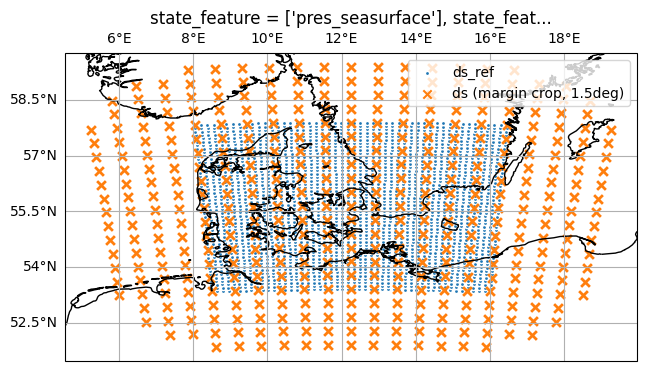

In [12]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 4))
xr.plot.scatter(ax=ax, ds=ds_reference, x="lon", y="lat", label="ds_ref", marker=".", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, ds=da_global_margin_crop, x="lon", y="lat", marker="x", label=f"ds (margin crop, {max_dist}deg)", transform=ccrs.PlateCarree())
ax.coastlines()
ax.legend()
ax.gridlines(draw_labels=["top", "left"])

In [13]:
max_dist = 1.5 # in degrees
ds_global_margin_crop_without_interior = cropping.crop_with_convex_hull(
    ds=ds_global, ds_reference=ds_lam, margin_thickness=max_dist, include_interior_points=False
)

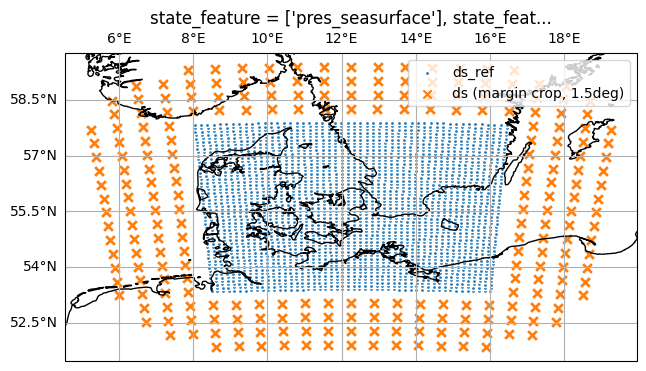

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 4))
xr.plot.scatter(ax=ax, ds=ds_reference, x="lon", y="lat", label="ds_ref", marker=".", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, ds=ds_global_margin_crop_without_interior, x="lon", y="lat", marker="x", label=f"ds (margin crop, {max_dist}deg)", transform=ccrs.PlateCarree())
ax.coastlines()
ax.legend()
ax.gridlines(draw_labels=["top", "left"])